# Demonstration of digital modulation principles

This demo is supposed to shed some light on the principles of [digital modulatio techniquies](https://en.wikipedia.org/wiki/Modulation#Digital_modulation_methods). 

This demo is written by [Markus Nölle](https://www.htw-berlin.de/hochschule/personen/person/?eid=9586) for a basic course on [communications engineering](https://en.wikipedia.org/wiki/Telecommunications_engineering) hold at the [university of applied siences, Berlin](https://www.htw-berlin.de/).

## Import libraries and set defaults

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ipywidgets as widgets

plt.style.use('noelle.mplstyle')

## General parameters

Basic parameters like sample rate, time axis and frequency axis are defined.

In [57]:
sr = 2000
symb_rate = 200 # symbol rate (has to be an even integer divider of sr)
fc = 100 # carrier frequency
levels = 2 # amplitude levels of I and Q
bipolar = True # unipolar or bipolar
quadrature = True # use quadrature modulation?
n_symb_show = 20


t = np.linspace(0, 1-1/sr, int(sr))
f = np.fft.fftshift(np.fft.fftfreq(np.size(t), 1/sr))
n = np.size(t) # length of signal
n_symb = symb_rate # always 1 s simulation time
sps = sr/symb_rate # samples per symbol


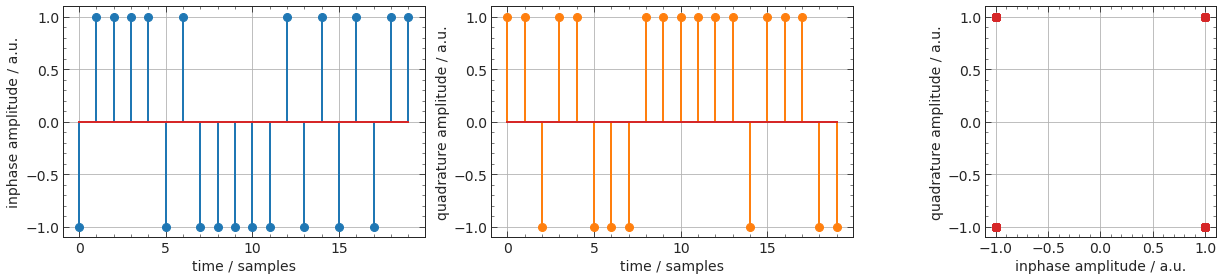

In [58]:
x_bits_i = np.random.randint(0, levels, n_symb)
x_bits_q = np.zeros_like(x_bits_i)

if bipolar:
    x_bits_i = (x_bits_i-(levels - 1)/2)*2

if quadrature:
    x_bits_q = np.random.randint(0, levels, n_symb)
    if bipolar:
        x_bits_q = (x_bits_q-(levels - 1)/2)*2

n_row = 1
n_col = 3
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
plt.stem(x_bits_i[0:n_symb_show], markerfmt='C0o', linefmt='C0', use_line_collection=True)
ax.set(xlabel="time / samples", ylabel="inphase amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
plt.stem(x_bits_q[0:n_symb_show], markerfmt='C1o', linefmt='C1', use_line_collection=True)
ax.set(xlabel="time / samples", ylabel="quadrature amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 3)
plt.plot(x_bits_i, x_bits_q ,'oC3')
ax.set(xlabel="inphase amplitude / a.u.", ylabel="quadrature amplitude / a.u.");
ax.set_aspect('equal','box')

plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


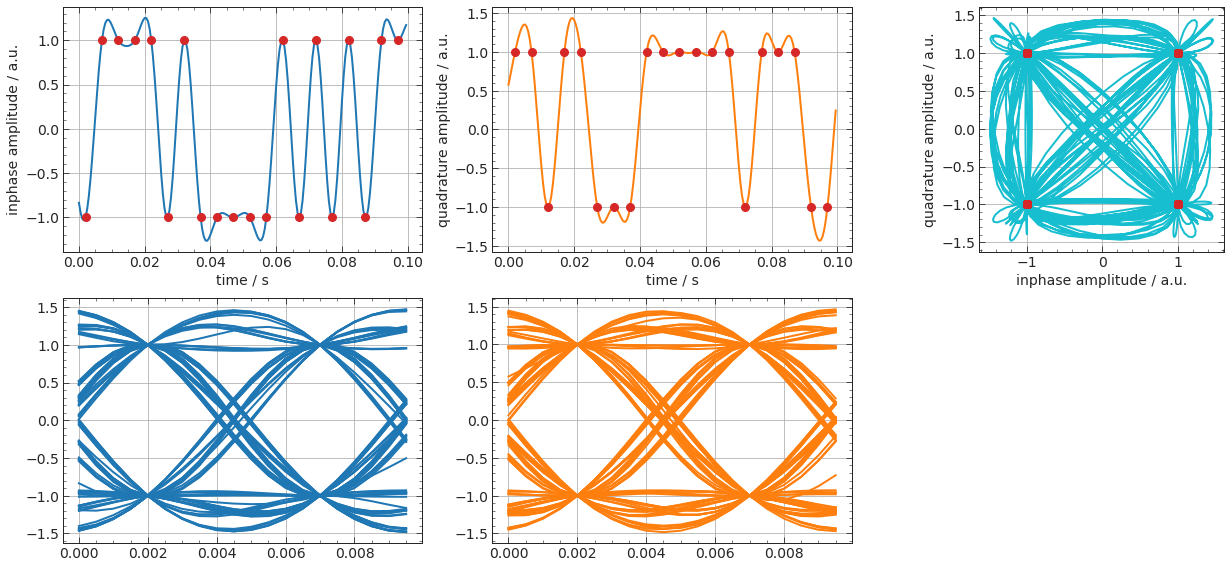

In [69]:
# # rect
# h = np.ones(int(sps))
    
# RC
alpha = 0.5
N = 20 * sps
t_filter = np.arange(-np.ceil(N/2)+1, np.floor(N/2)+1)
T = sps 
h = ((np.sin(np.pi*t_filter/T)) / (np.pi*t_filter/T)) * ((np.cos(alpha*np.pi*t_filter/T)) / (1-(2*alpha*t_filter/T)**2))
h[t_filter==0] = 1
h[np.abs(t_filter) == (T/(2*alpha))] = np.sin(np.pi/2/alpha) / (np.pi/2/alpha) * np.pi / 4

# # # RRC
# # alpha = 1;
# # N = 20 * upsam;
# # t = -ceil(N/2)+1:floor(N/2);
# # T = upsam;
# # h = 1/sqrt(T) .* (sin(pi.*t./T.*(1-alpha)) + 4.*alpha.*t./T.*cos(pi.*t./T.*(1+alpha))) ./ (pi.*t./T.*(1-(4.*alpha.*t./T).^2));
# # h(t==0) = 1./sqrt(T).*(1-alpha+4.*alpha./pi);
# # h(abs(t)==T./4./alpha) = alpha./sqrt(2.*T).*((1+2./pi).*sin(pi./4./alpha)+(1-2./pi).*cos(pi./4./alpha));


x_i = signal.upfirdn(h, x_bits_i, sps)
x_q = signal.upfirdn(h, x_bits_q, sps)

if x_i.size != x_bits_i.size*sps:
    cut = x_i.size-(np.max((x_bits_i.size*sps,h.size)))
    x_i = x_i[np.int(np.floor(cut/2)):-np.int(np.ceil(cut/2))]
    x_q = x_q[np.int(np.floor(cut/2)):-np.int(np.ceil(cut/2))]

n_row = 2
n_col = 3
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
plt.plot(t[0:np.int(n_symb_show*sps):], x_i[0:np.int(n_symb_show*sps):] ,'C0')
plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], x_bits_i[0:n_symb_show:],'oC3')
ax.set(xlabel="time / s", ylabel="inphase amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 4)
plt.plot(t[0:np.int(2*sps):], np.reshape(x_i,(np.int(2*sps),-1),order='F') ,'C0')

ax = fig.add_subplot(n_row, n_col, 2)
plt.plot(t[0:np.int(n_symb_show*sps):], x_q[0:np.int(n_symb_show*sps):] ,'C1')
plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], x_bits_q[0:n_symb_show:],'oC3')
ax.set(xlabel="time / s", ylabel="quadrature amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 5)
plt.plot(t[0:np.int(2*sps):], np.reshape(x_q,(np.int(2*sps),-1),order='F') ,'C1')

ax = fig.add_subplot(n_row, n_col, 3)
plt.plot(x_i, x_q ,'C9')
plt.plot(x_bits_i, x_bits_q ,'oC3')
ax.set(xlabel="inphase amplitude / a.u.", ylabel="quadrature amplitude / a.u.");
ax.set_aspect('equal','box')

plt.tight_layout()
    